<a href="https://colab.research.google.com/github/hisaom0419/my_python/blob/master/Tecan(ABE)_20221127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tecanで測定して得られたワークシートを解析するコード
OD595、FL1を想定している。FLが2色のケースがある場合、また作ります（HM)。

基本的には、96穴、各サンプルを８行に、横１２列サンプル分解析したシートを想定している。ただ、解析ウェルを限った場合にもサンプルシート（sample_file）を対応させることで解析可能。

必須入力項目は必須。
サブコードにもパラメータあり。必要に応じて変更。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd
%cd /content/drive/MyDrive/Colab Notebooks/
%ls

/content/drive/MyDrive/Colab Notebooks
 20221125_FIT2_ZPS1pro-mSca-I_M1M2ZCV.xlsx   Sample_sheet_KA.xlsx
 Copper_project/                             SeqIO.ipynb
 Data_Abe_promoter.xlsx                     'Tecan(ABE)_20221127.ipynb'
 orf_coding_all.fasta                       'Tecan(OD_FL1)_20221119.ipynb'
 PCA.ipynb                                   古いファイル/
 Reduction_analysis_20221119.ipynb


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import fftpack

In [ ]:
#もしインストールしていないなら
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 8.0 MB/s 


In [ ]:
#データ読み込み(ver.1.1.0)

#----必須入力項目----
sample_name = 'Abe_promoter' #グラフのタイトルにするサンプル名
data_file = '20221125_FIT2_ZPS1pro-mSca-I_M1M2ZCV.xlsx' #データシート。空の測定がある場合には'Blank'と記入
sample_file = 'Sample_sheet_KA.xlsx' #サンプルシート

#----ここまで----
max_cycle = len(pd.read_excel(data_file).columns) #最大読み取りサイクル数
graph_file_1 = 'Curve_Graph_' + sample_name + '.pdf' #波形グラフの保存ファイル名
graph_file_2 = 'MFL_MGR_Graph_' + sample_name + '.pdf' #MFL/MGRグラフの保存ファイル名
data = 'Data_' + sample_name + '.xlsx' #MFL/MGRデータの保存ファイル名
writer = pd.ExcelWriter(data, engine = 'xlsxwriter') #最大蛍光値・MGRを保存するファイル


Sample = pd.read_excel(sample_file, index_col=0).to_dict()["Sample"]
length = len(Sample)

if length == 96:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=46,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=46+96+5,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  
else:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=47,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=47+length+5,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))

#ウェル番号とサンプル名をマルチインデックスにしたデータフレームの作成（＋'Blank'を取り除く）
df_1c = pd.concat([df_1,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1).drop(index='Blank', level=1)
df_2c = pd.concat([df_2,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1).drop(index='Blank', level=1)

#ウェル番号とサンプル名をマルチインデックスにしたデータフレームの作成（＋'Blank'を取り除く）
#df_1c = pd.concat([df_1,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1).drop(index='Blank', level=1).sort_index(level='Sample')
#df_2c = pd.concat([df_2,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1).drop(index='Blank', level=1).sort_index(level='Sample')


#Sampleから任意のものを取り除く
Sample = {k: v for k, v in Sample.items() if 'Blank' not in v}
Sample = {k: v for k, v in Sample.items() if 'Co' not in v}
Sample = {k: v for k, v in Sample.items() if 'Zn' not in v}
Sample = {k: v for k, v in Sample.items() if 'Vec' in v}


Sample

{'G5': 'FIT2_Vec_–LU',
 'G10': 'ZPS1_Vec_–LU',
 'H5': 'FIT2_Vec_–U',
 'H10': 'ZPS1_Vec_–U'}

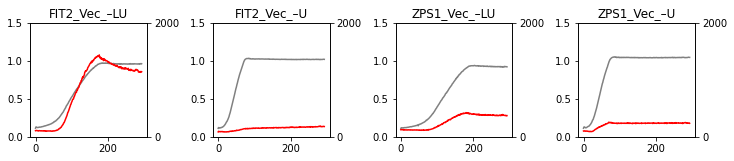

In [ ]:
#グラフ一覧作成 (ver.1.1.0)

#~~~~パラメータ~~~~
#グラフの縦軸の最大値
max_OD = 1.5
max_FL = 2000
FL_range = max_FL
graph_color = 'red' #グラフの色（蛍光色）
 
#~~~~ここまで~~~~

fig=plt.figure(figsize=(20,10))

n=0
x=np.arange(len(df_1c.T))

Sample_list = list(dict.fromkeys(list(Sample.values()))) #Sample_listを作り、並び替え
Sample_list.sort()

for sample in Sample_list: #重複なしサンプルリストから１つずつ実行

  n+=1
  #wellを抽出
  wells = [k for k, v in Sample.items() if v == sample]

  tdf1 = df_1c.loc[wells]
  tdf2 = df_2c.loc[wells]

  y1=tdf1.mean(axis=0)
  std1=tdf1.std(axis=0)
  y2=tdf2.mean(axis=0)
  std2=tdf2.std(axis=0)

  ax1=fig.add_subplot(5,8,n) #サンプル数に応じてグラフの数を変える。デフォルトはmax24
  
  ax1.plot(x,y1,color="gray")
  ax1.fill_between(x,y1-std1,y1+std1,alpha=0.5,color="gray")
  ax1.set_title(sample)
  #ax1.set_ylabel("OD")
  #ax1.set_xlabel("time(x10 min)")
  ax1.set_ylim(0, max_OD)
  
  ax2 = ax1.twinx() #2軸のグラフを描くため
  ax2.plot(x,y2,color=graph_color)
  ax2.fill_between(x,y2-std2,y2+std2,alpha=0.5,color=graph_color)
  ax2.set_ylim(0, max_FL)
  ax2.set_yticks(np.arange(0,max_FL+1,FL_range))
  #ax2.set_ylabel("Intensity")
 
plt.tight_layout()
plt.show()

#グラフを保存
#fig.savefig(graph_file_1)

In [ ]:
#MGR算出ファイル（ver.2.1.0）
#"zero-size array" エラー処理を加えた

#~~~~パラメータ~~~~
Period = 30 #測定間隔（min）
Range = 10 #GRを算出するレンジ
Step_size = 1 #移動測定数（大きくすると処理が早くなる）
Threshold = 0.9 #R2の閾値を指定
graph_color = 'red' #グラフの色（蛍光色）
#~~~~ここまで~~~~

#データをログ変換
OD_log2 = np.log2(df_1c).dropna()
Max_cycle = len(OD_log2.columns)-1
#print(Max_cycle)
Well_Num = len(OD_log2) 
x = np.arange(Range)

MGR = OD_log2[1]

#WellごとにTimeウインドウを移動しながらGR（直線回帰の傾き=SlopeとR2を取得）、R2のThreshold以上のSlopeを返す（Threshold以下だと0.01を返す）。
#最終的なGRは測定時間間隔（Period）で割り(min-1)、便宜的に10をかけている。

for index in MGR.index:
  Cycle = 0
  n = 0
  Slope  = np.array([])
  R2 = np.array([])
  OD_list = OD_log2.loc[index].values


  while Cycle < Max_cycle-Range:
    #OD_list2 = OD_list[Cycle:Cycle+Range]
    OD_list2 = np.roll(OD_list,Cycle)[0:Range]
    Slope = np.insert(Slope,n,(np.polyfit(x,OD_list2,1)[0]*100))
    R2 = np.insert(R2,n,(np.corrcoef(x,OD_list2)[0][1]**2))
    Cycle += Step_size
    n += 1

  GR = np.array([x for x in Slope[R2 > Threshold]])/Period*10

  #MGRを得る。R2の条件を満たさない場合には0.1を代入
  try:
    MGR[index] = GR.max()
  except ValueError:
    MGR[index] = 0.1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


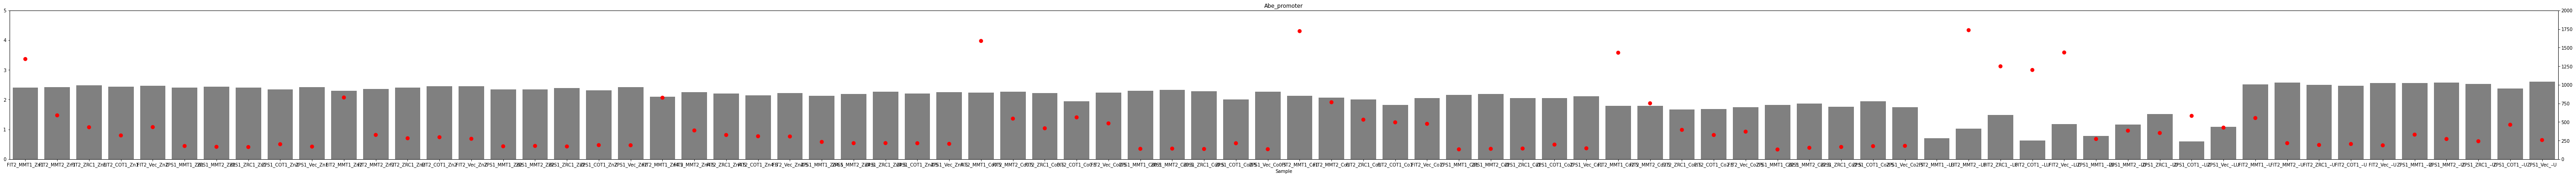

In [ ]:
#MGRと最高蛍光値のグラフ化、保存（ver.1.1.0）

#~~~~パラメータ~~~~
MGR_max = 5 #MGRグラフ最大値
MFL_max = 2000 #MFLグラフ最大値
#~~~~ここまで~~~~

fig=plt.figure(figsize=(100, 6))

ax1=fig.add_subplot()
ax1=sns.barplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray',capsize=0.2)
#ax1=sns.stripplot(MGR.index.get_level_values('Sample'), MGR.values,color='black')
#ax1.set_ylabel("MGR")
ax1.set_ylim(0, MGR_max)

MFL = df_2c.max(axis=1)

ax2 = ax1.twinx() #2軸のグラフを描くため
ax2=sns.pointplot(MFL.index.get_level_values('Sample'), MFL.values,color='red',join=False,capsize=0.2)
#ax2=sns.stripplot(MFL.index.get_level_values('Sample'), MFL.values,color='red')

#ax2.set_ylabel("Intensity")
ax2.set_ylim(0, MFL_max)

ax1.set_title(sample_name)

plt.show()

#グラフを保存
#fig.savefig(graph_file_2)


#データ保存
#MFL.to_excel(writer, sheet_name = 'MFL')
#MGR.to_excel(writer, sheet_name = 'MGR')

#writer.save()
#writer.close()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


     Sample       
A1   FIT2_MMT1_Zn1    1.1889
A2   FIT2_MMT2_Zn1    1.1523
A3   FIT2_ZRC1_Zn1    1.1827
A4   FIT2_COT1_Zn1    1.1502
A5   FIT2_Vec_Zn1     1.1541
                       ...  
H6   ZPS1_MMT1_–U     1.0257
H7   ZPS1_MMT2_–U     1.0238
H8   ZPS1_ZRC1_–U     0.9923
H9   ZPS1_COT1_–U     1.0408
H10  ZPS1_Vec_–U      1.0491
Length: 80, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


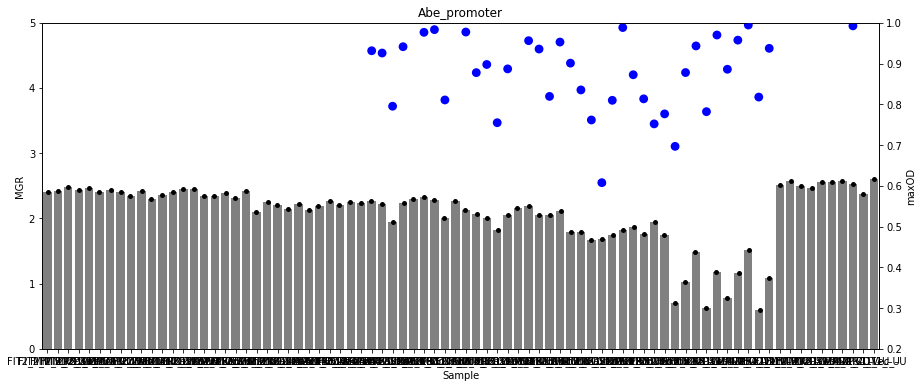

In [ ]:
#最高OD値のグラフ化
#~~~~パラメータ~~~~
maxOD = 1.0
#~~~~ここまで~~~~

fig=plt.figure(figsize=(15, 6))

ax1=fig.add_subplot()
ax1=sns.barplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray',capsize=0.2)
ax1=sns.stripplot(MGR.index.get_level_values('Sample'), MGR.values,color='black')
ax1.set_ylabel("MGR")
ax1.set_ylim(0, MGR_max)

MOD = df_1c.max(axis=1)
print(MOD)

ax2 = ax1.twinx() #2軸のグラフを描くため
ax2=sns.pointplot(MOD.index.get_level_values('Sample'), MOD.values,color='blue',join=False,capsize=0.2)
ax2=sns.stripplot(MOD.index.get_level_values('Sample'), MOD.values,color='blue')

ax2.set_ylabel("maxOD")
ax2.set_ylim(0.2, maxOD)

ax1.set_title(sample_name)

plt.show()